# 5章 誤差逆伝播法

## 単純なレイヤの実装

### 乗算レイヤの実装

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

In [2]:
apple = 100
apple_num = 2
tax = 1.1

#### Layer

In [3]:
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

#### Forward

In [4]:
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


#### backward

In [5]:
dprice = 1

In [6]:
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


### 加算レイヤの実装

In [7]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
    
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        
        return dx, dy

In [8]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

#### Layer

In [9]:
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

#### Forward

In [10]:
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

print(price)

715.0000000000001


#### Backward

In [11]:
dprice = 1

In [12]:
dall_price , dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple_num, dapple, dorange, dorange_num, dtax)

110.00000000000001 2.2 3.3000000000000003 165.0 650


## 活性化関数レイヤの実装

### ReLUレイヤ

In [13]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

In [14]:
import numpy as np

In [15]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)
mask = (x <= 0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


### Sigmoidレイヤ

In [16]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx

## Affine/Softmaxレイヤの実装

### Affineレイヤ

In [17]:
X = np.random.rand(2)
W = np.random.rand(2, 3)
B = np.random.rand(3)

print(X.shape)
print(W.shape)
print(B.shape)

Y = np.dot(X, W) + B
print(Y)

(2,)
(2, 3)
(3,)
[ 0.52666922  0.91274761  1.47332264]


### バッチ版Affineレイヤ

In [18]:
X_dot_W = np.array([[0, 0, 0], [10, 10, 10]])
B = np.array([1, 2, 3])

print(X_dot_W)
print(X_dot_W + B)

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]


In [19]:
dY = np.array([[1, 2, 3], [4, 5, 6]])
print(dY)

dB = np.sum(dY, axis = 0)
print(dB)

[[1 2 3]
 [4 5 6]]
[5 7 9]


In [20]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        
        return dx

### Softmax-with-Lossレイヤ

In [21]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

In [22]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [23]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.x = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.t, self.t)
        
        return self.loss
    
    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

## 誤差逆伝播法の実装

### 誤差逆伝播法に対応したニューラルネットワークの実装

In [24]:
import sys, os
os.chdir('./deep-learning-from-scratch/ch05')
sys.path.append(os.pardir)
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b2"] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["Relu1"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1 : t = np.argmax(t, axis = 1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        
        return grads
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db
        
        return grads

### 誤差逆伝播法の勾配確認

In [25]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + " : " + str(diff))

W2 : 8.78545553167e-13
W1 : 2.38498822885e-13
b1 : 7.74405745693e-13
b2 : 1.20126124326e-10


### 誤差逆伝播法を使った学習

In [26]:
network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

epoch_num = 0

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grads[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        epoch_num += 1
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(train_acc, test_acc)

0.147616666667 0.1487
0.90565 0.9075
0.92475 0.9257
0.9361 0.9351
0.944466666667 0.9431
0.951133333333 0.9481
0.955916666667 0.9524
0.95905 0.9562
0.961016666667 0.9576
0.965283333333 0.9592
0.96765 0.9613
0.9691 0.9625
0.971433333333 0.9632
0.973033333333 0.9654
0.974033333333 0.9657
0.976266666667 0.9669
0.976466666667 0.9687


In [27]:
import matplotlib.pylab as plt

%matplotlib inline

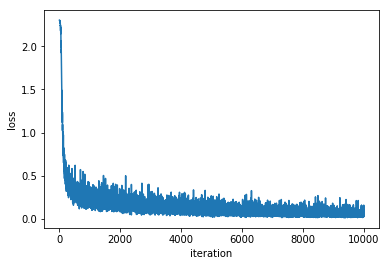

In [28]:
x = np.arange(0, iters_num, 1)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(x, train_loss_list)
plt.show()

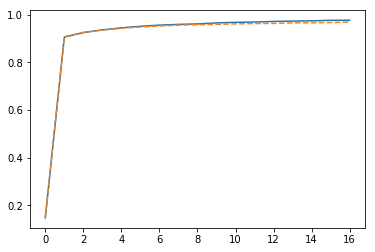

In [29]:
x = np.arange(0, epoch_num, 1)
plt.plot(x, train_acc_list)
plt.plot(x, test_acc_list, linestyle = "--")
plt.show()